# 1.4: Bike Share III (Sweeping Parameters)

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap01 import change_func

import pandas as pd

In the previous chapter we defined metrics that quantify the performance of a bike sharing system.
In this chapter we'll see how those metrics depend on the parameters of the system, like the arrival rate of customers at the stations.

And I will present a program development strategy, called incremental
development, that might help you write programs faster and spend less
time debugging.

## Functions That Return Values

We have used several functions that return values.
For example, when you run `sqrt`, it returns a number you can assign to a variable.

In [2]:
from numpy import sqrt

root_2 = sqrt(2)
root_2

1.4142135623730951

When we run `pd.Series`, it returns a new state object:

In [3]:
bikeshare = pd.Series(dict(augie=10,moline=2),name='Number of Bikes')
bikeshare

augie     10
moline     2
Name: Number of Bikes, dtype: int64

Not all functions have return values. For example, when you run `change_func`,
it updates a state object, but it doesn't return a value.

To write functions that return values, we can use a `return` statement, like this:

In [4]:
def add_five(x):
    return x + 5

`add_five` takes a parameter, `x`, which could be any number. It
computes `x + 5` and returns the result. So if we run it like this, the
result is `8`:

In [5]:
add_five(3)

8

As a more useful example, here's a version of `run_simulation` that
creates a state object, runs a simulation, and then returns the
state object:

In [6]:
def run_simulation(p1, p2, num_steps):
    state = pd.Series(dict(augie=10,moline=2,augie_empty=0,moline_empty=0,
                           clock=0),name="Number of Bikes")
    
    for i in range(num_steps):
        change_func(state, p1, p2)
        
    return state

We can call `run_simulation` like this:

In [7]:
final_state = run_simulation(0.3, 0.2, 100)

The result is a `State` object that represents the final state of the system, including the metrics we'll use to evaluate the performance of the system:

In [8]:
print(final_state.augie_empty, 
      final_state.moline_empty)

0 1


The simulation we just ran starts with `augie=10` and `moline=2`, and uses the values `p1=0.3`, `p2=0.2`, and `num_steps=100`. 
These five values are *parameters of the model*, which are quantities that determine the behavior of the system.

It is easy to get the parameters of a model confused with the parameters of a function. 
It is especially easy because the parameters of a model often appear as parameters of a function.

For example, the previous version of `run_simulation` takes `p1`, `p2`, and `num_steps` as parameters.
So we can call `run_simulation` with different parameters and see how
the metrics, like the number of unhappy customers, depend on the
parameters. But before we do that, we need a new version of a `for` loop.

## Loops and Arrays

In `run_simulation`, we use this `for` loop:

```
    for i in range(num_steps):
        change_func(state, p1, p2)
```

In this example, `range` creates a sequence of numbers from `0` to `num_steps` (including `0` but not `num_steps`). 
Each time through the loop, the next number in the sequence gets assigned to the loop variable, `i`.

But `range` only works with integers; to get a sequence of non-integer
values, we can use `linspace`, which is defined NumPy:

In [9]:
from numpy import linspace

p1_array = linspace(0, 1, 5)
p1_array

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

The arguments indicate where the sequence should start and stop, and how
many elements it should contain. In this example, the sequence contains
`5` equally-spaced numbers, starting at `0` and ending at `1`.

The result is a NumPy *array*, which is a new kind of object we have
not seen before. An array is a container for a sequence of numbers.

We can use an array in a `for` loop like this:

In [10]:
for p3 in p1_array:
    print(p3)

0.0
0.25
0.5
0.75
1.0


When this loop runs, it

1.  Gets the first value from the array and assigns it to `p1`.

2.  Runs the body of the loop, which prints `p1`.

3.  Gets the next value from the array and assigns it to `p1`.

4.  Runs the body of the loop, which prints `p1`.

5. ...

And so on, until it gets to the end of the array. This will come in handy in the next section.

## Sweeping Parameters

If we know the actual values of parameters like `p1` and `p2`, we can
use them to make specific predictions, like how many bikes will be at
Augustana after one hour.

But prediction is not the only goal; models like this are also used to
explain why systems behave as they do and to evaluate alternative
designs. For example, if we observe the system and notice that we often run out of bikes at a particular time, we could use the model to figure out why that happens. And if we are considering adding more bikes, or another station, we could evaluate the effect of various "what if" scenarios.

As an example, suppose we have enough data to estimate that `p2` is
about `0.2`, but we don't have any information about `p1`. We could run simulations with a range of values for `p1` and see how the results vary. This process is called *sweeping* a parameter, in the sense that the value of the parameter "sweeps" through a range of possible values.

Now that we know about loops and arrays, we can use them like this:

In [11]:
p1_array = linspace(0, 0.6, 6)
p2 = 0.2
num_steps = 60

for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    print(p1, final_state.augie_empty)

0.0 0
0.12 0
0.24 0
0.36 0
0.48 11
0.6 11


Each time through the loop, we run a simulation with a different value
of `p1` and the same value of `p2`, `0.2`. Then we print `p1` and the
number of unhappy customers at Augustana.

To save and plot the results, we can use another `Series`.  But in this case, the labels are the different parameter values (i.e. the arrival rates in Moline) rather than time values or state variable names, and the values in the `Series` will be the number of unhappy customers produced by each arrival rate.

In [12]:
sweep = pd.Series([],name = "Unhappy Customers",dtype=object)

And add values like this:

In [13]:
p1_array = linspace(0.1, 0.6, 31)

for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    sweep[p1] = final_state.augie_empty

The result is a `Series` that maps from each value of `p1` to the
resulting number of unhappy customers.

We can display the results like this:

In [14]:
pd.DataFrame(sweep)

,Unhappy Customers
0.100000,0
0.116667,0
0.133333,0
0.150000,0
0.166667,0
0.183333,0
0.200000,0
0.216667,0
0.233333,0
0.250000,0


We can plot the results like this:

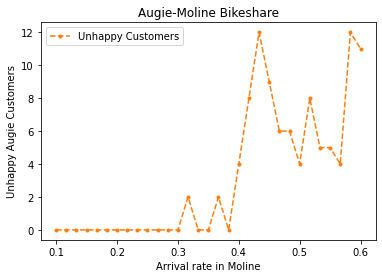

In [15]:
sweep.plot(xlabel="Arrival rate in Moline", 
           ylabel="Unhappy Augie Customers",
            title='Augie-Moline Bikeshare',
            color='C1',legend=True,
            linestyle='--',marker='.');

The keyword argument `color='C1'` specifies the color of the line. The keyword arguments `marker` amd `linestyle` control the style of the plot.  Do a web search for 'matplotlib plot' to see available options.

When the arrival rate at Augustana is low, there are plenty of bikes and no unhappy customers.
As the arrival rate increases, we are more likely to run out of bikes and the number of unhappy customers increases. The line is jagged because the simulation is based on random numbers. Sometime we get lucky and there are relatively few unhappy customers; other times are are unlucky and there are more. 

## Incremental Development

When you start writing programs that are more than a few lines, you
might find yourself spending more time debugging. The more code you write before you start debugging, the harder it is to find the problem.

*Incremental development* is a way of programming that tries to
minimize the pain of debugging. The fundamental steps are:

1.  Always start with a working program. If you have an example from a
    book, or a program you wrote that is similar to what you are working
    on, start with that. Otherwise, start with something you *know* is
    correct, like `x=5`. Run the program and confirm that it does what
    you expect.

2.  Make one small, testable change at a time. A "testable" change is
    one that displays something or has some other effect you can check.
    Ideally, you should know what the correct answer is, or be able to
    check it by performing another computation.

3.  Run the program and see if the change worked. If so, go back to
    Step 2. If not, you have to do some debugging, but if the
    change you made was small, it shouldn't take long to find the
    problem.

When this process works, your changes usually work the first time, or if they don't, the problem is obvious. In practice, there are two problems with incremental development:

-   Sometimes you have to write extra code to generate visible output
    that you can check. This extra code is called *scaffolding*
    because you use it to build the program and then remove it when you
    are done. That might seem like a waste, but time you spend on
    scaffolding is almost always time you save on debugging.

-   When you are getting started, it might not be obvious how to choose
    the steps that get from `x=5` to the program you are trying to
    write. You will see more examples of this process as we go along,
    and you will get better with experience.

If you find yourself writing more than a few lines of code before you
start testing, and you are spending a lot of time debugging, try
incremental development.

## Summary

This chapter introduces functions that return values, which we use to write a version of `run_simulation` that returns a `State` object with the final state of the system.

It also introduces `linspace`, which we use to create a NumPy array, and sweep `Series`, which we use to store the results of a parameter sweep.

We used a parameter sweep to explore the relationship between one of the parameters, `p1`, and the number of unhappy customers, which is a metric that quantifies how well (or badly) the system works.

In the exercises, you'll have a chance to sweep other parameters and compute other metrics.

In the next chapter, we'll move on to a new problem, modeling and predicting world population growth.

## Exercises

### Exercise 1

 Write a function called `make_state` that creates a state object with the state variables `augie=10` and `moline=2`, and then returns the new state object.

Write a line of code that calls `make_state` and assigns the result to a variable named `init`.  Finally, show the values of the state variables in 'init'.

In [16]:
def make_state():
    state = pd.Series(dict(augie=10,moline=2),name="Number of Bikes")
    return state

In [17]:
init = make_state()
pd.DataFrame(init)

,Number of Bikes
augie,10
moline,2


### Exercise 2

Read the documentation of `linspace` at <https://numpy.org/doc/stable/reference/generated/numpy.linspace.html>. Then use it to make an array of 101 equally spaced points between 0 and 1 (including both).  Show the values within the array to check your solution.

In [18]:
hundred = linspace(0,1,101)
show(hundred)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

### Exercise 3

 Wrap the `run_simulation` in a function named `sweep_p1` that finds the number of unhappy customers at Augustana for a range of probabilities.  The function should take three parameters: an array called `p1_array` that defines the range of `p1` values, a value between 0 and 1 called `p2`, and an integer value called `num_steps`.  It should create a new sweep `Series` and run a `num_steps` simulation for each value of `p1` in `p1_array` and the provided `p2`.
 
It should store the results in the `Series` and return the `Series`.  

In the second box, use your function to plot the number of unhappy customers at Augustana as a function of `p1` when `p2` = 0.2 and `num_steps` = 60.   Label the axes.

In [19]:
# Define function sweep_p1

def sweep_p1(p1_array,p2,num_steps):
    """"Finds the number of unhappy customers at Augustana for a range of 
    probabilities p1
    
    p1: probability of a customer arrival at Augustana
        in a given time step
    p2: probability of a customer arrival at Moline
        in a given timestep
    num_steps: number of time steps"""
    
    #Create sweep Series state object save augie_empty results
    sweep = pd.Series([],dtype=object)
    for p1 in p1_array:
        # Create state object to hold results
        final_state = run_simulation(p1, p2, num_steps)
        # Inserts result into sweep Series
        sweep[p1] = final_state.augie_empty
    return sweep

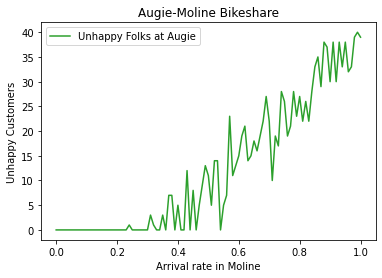

In [20]:
# Define particular solution and plot solution

p1_array = linspace(0,1,101)
p1_sweep = sweep_p1(p1_array,0.2,60)

p1_sweep.plot(xlabel="Arrival rate in Moline", 
           ylabel="Unhappy Customers",
            title='Augie-Moline Bikeshare',
            color='C2',label='Unhappy Folks at Augie',legend=True);


### Exercise 4

 Write a similar function (also finding the unhappy customers at Augustana) called `sweep_p2` that runs simulations with `p1=0.5` and a range of values for `p2`.  It should store the results in a `Series` and return the `Series`.  Use cut-and-paste to your advantage!


In [21]:
def sweep_p2(p1,p2_array,num_steps):
    
    """"Finds the number of unhappy customers at Augustana for a range of 
    probabilities p1
    
    p1: probability of a customer arrival at Augustana
        in a given time step
    p2: probability of a customer arrival at Moline
        in a given timestep
    num_steps: number of time steps"""
    
    sweep = pd.Series([],dtype=object)
    
    for p2 in p2_array:
        final_state = run_simulation(p1, p2, num_steps)
        sweep[p2] = final_state.augie_empty
    return sweep

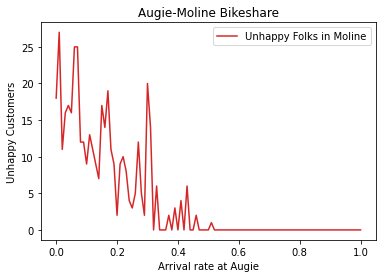

In [22]:
p2_array = linspace(0,1,101)
p2_sweep = sweep_p2(0.5,p2_array,60)

p2_sweep.plot(xlabel="Arrival rate at Augie", 
           ylabel="Unhappy Customers",
            title='Augie-Moline Bikeshare',
            color='C3',label='Unhappy Folks in Moline',legend=True);

## Challenge Exercises

The following two exercises are a little more challenging.  If you are comfortable with what you have learned so far, you should give them a try.  If you feel like you have your hands full, you might want to skip them for now.

### Exercise 5

 Because our simulations are random, the results vary from one run to another, and the results of a parameter sweep tend to be noisy.  We can get a clearer picture of the relationship between a parameter and a metric by running multiple simulations with the same parameter and taking the average of the results.

Write a function called `run_multiple_simulations` that takes as parameters `p1`, `p2`, `num_steps`, and `num_runs`.
`num_runs` specifies how many times it should call `run_simulation`.

After each run, it should store the total number of unhappy customers (at Augustana and Moline combined) in a time `Series`.
At the end, it should return the `Series`.

In the second cell, test your function with parameters and show the result `Series`:

```
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
```

In the third cell, use the `mean` function from NumPy to compute the average number of unhappy customers (see "Under The Hood" section below to see how to do this).

In [23]:
## Defines the function that runs multiple simulations for 
## a given p1 and p2 and saves the results in a time Series

def run_multiple_simulations(p1,p2,num_steps,num_runs):
    local_results = pd.Series([],dtype=object)
    
    for i in range(num_runs):
        state = run_simulation(p1, p2, num_steps)
        local_results[i] = state.augie_empty + state.moline_empty
    return local_results
    

In [24]:
results = run_multiple_simulations(0.6,0.3,60,20)
pd.DataFrame(results)


,0
0,17
1,8
2,21
3,16
4,10
5,19
6,0
7,12
8,18
9,13


In [25]:
print('The average number of unhappy customers is ',results.mean())

The average number of unhappy customers is  11.7


### Exercise 6

Continuing the previous exercise, use `run_multiple_simulations` to run simulations with a range of values for `p1` and

```
p2 = 0.3
num_steps = 60
num_runs = 20
```

Store the results in a sweep `Series`, then plot the average number of unhappy customers as a function of `p1`.  Label the axes.

What value of `p1` minimizes the average number of unhappy customers?

In [26]:
## num_p1 defines the number of values for p1, evenly spaced 
##between 0 and 1, that will be modelled
num_p1 = 21
p1_array = linspace(0,1,num_p1)

## p2 is the value for p2 (chance of a customer picking up a 
## bike from Moline)
p2 = 0.3

## num_steps is the number of time steps in each simulation
num_steps = 60

## num_runs is the number of simulations run for each value of p1
num_runs = 100

## unhappy will store the average number of combined unhappy customers for each value of p1
unhappy = pd.Series([],dtype=object)
for p1 in p1_array:
    results = run_multiple_simulations(p1,p2,num_steps,num_runs)
    unhappy[p1]= results.mean()

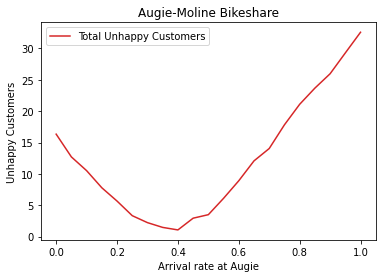

In [27]:
unhappy.plot(xlabel="Arrival rate at Augie", 
           ylabel="Unhappy Customers",
            title='Augie-Moline Bikeshare',
            color='C3',label='Total Unhappy Customers',legend=True);

### Exercise 7

Take a moment and look at the results from exercise 6.  What is the ideal arrival rate in order to minimize unhappy customers?  Look at the parameters, and explain in a couple sentences why that makes sense.

Then change some of the parameters (`num_steps`,`p2`).  What do you expect to happen to the optimal arrival rate?  Rerun the experiments with changed paramters: does it change as you'd expect?

Answer in a Markdown cell below this one.

## Under the Hood

`Series` provides a number of functions, which you can read about at <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html>.

They include `mean`, which computes the average of the values in the `Series`, so if you have a `Series` named `totals`, for example, you can compute the mean like this:

```
    totals.mean()
```

`Series` provides other statistical functions, like `std`, which computes the standard deviation of the values in the series.

In this chapter I use the keyword argument `color` to specify the color of a line plot.
You can read about the other available colors at <https://matplotlib.org/3.3.2/tutorials/colors/colors.html>.